In [0]:
import numpy as np
from scipy.integrate import complex_ode
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

(-1+0j)


Nous commençons par le contrôle optimal (i.e qui minimise l'énergie dépensée). Nous allons le tester dans le cas où l'énergie n'est pas tout à fait E. 


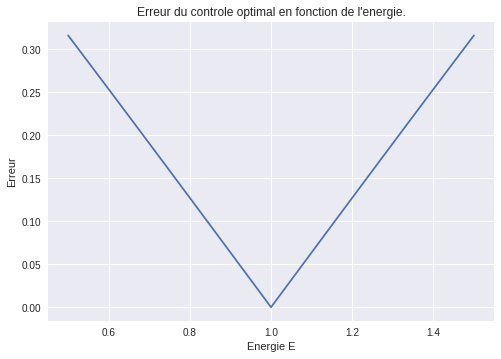

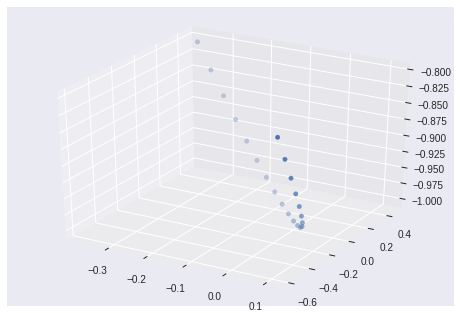

In [0]:
def controle_optimal(t, T, E, Phi=0): #definit le controle Omega optimal
  return np.pi/(2*T)*np.exp(-1j*E*2*t)*np.exp(-1j*Phi)
  #le phi est optionnel car change la trajectoire juste par une rotation
  
  
def H_0(E, Omega):
  return np.array([[E, Omega],
                   [np.conjugate(Omega), -E]])

def derivee_Psi(E, Omega, Psi):
  h = H_0(E, Omega)
  return -1j*np.dot(h, Psi)

def evolution_Psi(E, omega, T, N):
  "Pour le controle optimal."
  liste_Psis = np.zeros((N, 2), dtype=np.complex_)
  liste_tps = [0.0]*N
  liste_Psis[0] = np.array([1.0, 0.0])
  T = float(T)
  f = lambda t, y: derivee_Psi(E, omega(t), y)
  r = complex_ode(f)
  r.set_initial_value(liste_Psis[0], liste_tps[0])
  dt = T/(N-1)
  k = 1
  while r.successful() and k < N:
    liste_tps[k] = r.t+dt
    liste_Psis[k] = r.integrate(r.t + dt)
    k += 1
  return liste_tps, liste_Psis

def psi_to_cartesien(psi):
  p1, p2 = psi[0], psi[1]
  a = np.conjugate(p1)*p2
  return np.array([2*np.real(a), 2*np.imag(a), np.absolute(p1)**2 - np.absolute(p2)**2])

def erreur_controle(controle, T, N, Es):
  erreur, vs = [], []
  for E in Es:
    tps, psis = evolution_Psi(E, controle, T, N)
    v = psis[-1]
    vs.append(v)
    erreur.append(np.sqrt(np.absolute(v[0])**2 + (1-np.absolute(v[1]))**2))
    #distance entre notre vecteur et le vecteur (0, 1) au temps 
  return Es, vs, erreur
  
  
def tracer_vecteurs_erreur(Es, vs, erreur):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  carts = [psi_to_cartesien(v) for v in vs]
  x = [v[0] for v in carts] 
  y = [v[1] for v in carts]
  z = [v[2] for v in carts]
  ax.scatter(x, y, z)
  plt.show()

E_0 = 1.0
Es = [0.5 + 0.05*k for k in range(21)]
T = 1.0
N = 100

controle = lambda t: controle_optimal(t, T, E_0)
Es, vs, erreur = erreur_controle(controle, T, N, Es)

plt.plot(Es, erreur)
plt.xlabel("Energie E")
plt.ylabel("Erreur")
plt.title("Erreur du controle optimal en fonction de l'energie.")

tracer_vecteurs_erreur(Es, vs, erreur)

Nous commençons par définir la fonction pour calculer l'évolution du vecteur $ \Phi $, en fonction de la matrice H(u, v)

In [0]:
def U_rotation(E, delta_t, t): #Calcule la matrice de rotation Psi -> Phi
  a = 1j * (E*t + delta_t/2)
  return np.array([[np.exp(a), 0.0],
                   [0.0, np.exp(-a)]])

def H_u_v(alpha, E, controle): #matrice d'évolution de l'état Phi
  u,v = controle
  w = v/2 - (alpha - 1.0)*E
  return np.array([[-w, u], 
                   [u, w]])

def derivee_Phi(alpha, E, controle, Phi):
  return -1j * np.dot(H_u_v(alpha, E, controle), Phi)

Nous allons maintenant définir le contrôle $\gamma$ sous la forme d'un demi-cercle. 

In [0]:
#On définit l'évolution du controle (u(t), v(t)) sous la forme d'un demi-cercle
#(car on peut calculer analytiquement l'évolution de l'état Phi avec ce contrôle)

def gamma(t): #en t = 0 : (0, -1); en t = 1 : (0, 1)
  return (np.sin(t*np.pi), -np.cos(t*np.pi))

def gamma_0(t):
  "On rajoute ici un facteur 2 a v pour compenser le facteur 1/2 qui apparait dans\
  la matrice H. "
  return (np.sin(t*np.pi), -2*np.cos(t*np.pi))

def gamma_scale(t, v_i, v_f): 
  "change l'echelle du controle pour s'adapter aux valeurs de alpha"
  if v_i > v_f:
    v_f, v_i = v_i, v_f
  milieu = (v_i + v_f)/2
  ecart = (v_f - v_i)/2 #rayon du cercle 
  g = gamma(t)
  return (g[0]*ecart, g[1]*ecart + milieu)    

def gamma_0_scale(t, v_i, v_f):
  "Meme chose que pour gamma_scale mais avec gamma_0"
  if v_i > v_f:
      v_f, v_i = v_i, v_f
  milieu = (v_i + v_f)/2
  ecart = (v_f - v_i)/2 #rayon du cercle 
  g = gamma_0(t)
  return (g[0]*ecart, g[1]*ecart + milieu)    

def contraintes_v(E, alpha_min, alpha_max):
  "retourne les valeurs (v_min,v_max) pour que le controle fonctionne \
  en fonction des valeurs alpha_min et alpha_max"
  assert alpha_min < 1 and alpha_max > 1
  return (2*(alpha_min - 1)*E, 2*(alpha_max- 1)*E) #il faut v_i < v_min, v_f > v_max

Ci-dessous nous affichons la représentation graphique du contrôle $\gamma$. 

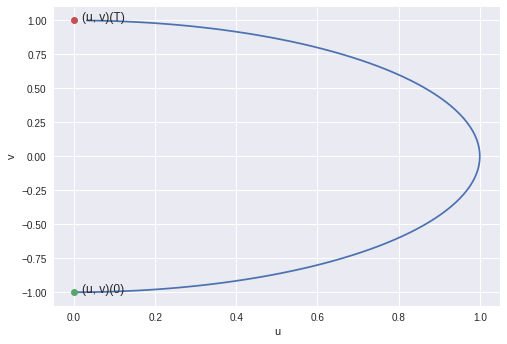

In [0]:
def afficher_controle_2D(v_i, v_f): #affiche le demi cercle
  controle = lambda t : gamma_scale(t, v_i, v_f)
  ts = [k/float(100) for k in range(100)]
  u, v = [], []
  for t in ts:
    c = controle(t)
    u.append(c[0])
    v.append(c[1])
  plt.plot(u, v)
  plt.plot([0.0], [-1.0], marker='o')
  plt.text(0.02, -1.0, "(u, v)(0)")
  plt.plot([0.0], [1.0], marker='o')
  plt.text(0.02, 1.0, "(u, v)(T)")
  plt.xlabel("u")
  plt.ylabel("v")  
  plt.show()

afficher_controle_2D(-1.0, 1.0)

In [0]:
Phi_init = np.array([1.0, 0.0])
Phi_cible= np.array([0.0, 1.0])

def evolution_Phi(alpha, E, controle, T, N): 
  "Prend en argument la fonction gamma qui sera l'evolution de notre controle\
  ainsi que l'etat initial, le temps final et le nombre de pas\
  on va faire une homothetie temporelle pour que gamma aille de 0 a T."
  liste_Phis = np.zeros((N, 2), dtype=np.complex_)
  liste_tps = [0.0]*N
  liste_Phis[0] = Phi_init
  T = float(T)
  f = lambda t, y: derivee_Phi(alpha, E, controle(t/T), y)
  r = complex_ode(f)
  r.set_initial_value(liste_Phis[0], liste_tps[0])
  dt = T/(N-1)
  k = 1
  while r.successful() and k < N: #k < N
    liste_tps[k] = r.t+dt
    liste_Phis[k] = r.integrate(r.t + dt)
    k += 1
  return liste_tps, liste_Phis

def vecteur_final(alpha, E, controle, T, N):
  "Retourne le vecteur au temps T."
  liste_tps, liste_Phis = evolution_Phi(alpha, E, controle, T, N)
  return liste_Phis[N-1]

def distance_finale(alpha, E, controle, T, N): 
  "retourne la distance finale au vecteur (0, 1), A ROTATION PRES"
  vec_final = vecteur_final(alpha, E, controle, T, N)
  a, b = vec_final[0], vec_final[1]
  #doit normalement croitre comme epsilon^2
  return np.absolute(a)**2 + (1-np.absolute(b))**2


In [0]:
"""
Fonctions d'affichage des resultats
"""

def afficher_evolution_Phi(liste_tps, liste_Phis):
  "Affiche les deux composantes du vecteur Phi en fonction du temps"
  plt.plot(liste_tps, np.absolute(liste_Phis[:, 0]))
  plt.plot(liste_tps, np.absolute(liste_Phis[:, 1]))
  plt.show()
  
def distances_finales_alpha(controle):
  "Calcule la distance de l'etat final au vecteur (0, 1) (a rotation pres) en fonction de alpha"
  alphas, distances = [], []
  alpha = alpha_min
  while alpha < alpha_max:
    distance = distance_finale(alpha, E, controle, T, N)
    alphas.append(alpha)
    distances.append(distance)
    alpha += alpha_step
  return alphas, distances

def coefficient_reel(e):
  "Ici, epsilon = 1/T, retourne le coefficient (dont il faudra prendre la valeur absolue\
  ou le carre)"
  return -np.sin(np.sqrt(1+(np.pi*np.pi*e*e/4))/e)/np.sqrt(1+(np.pi*np.pi*e*e/4))*np.pi*e/2

def graphe_distance_epsilon(): 
  "Dans ce cas, on fixe alpha = 1 et on regarde la distance finale au temps T en fonction de T = 1/epsilon"
  epsilons = [0.025 + 0.001*k for k in range(1, 1001)]
  Ts = [1/e for e in epsilons]
  controle = lambda t : gamma_0(t)
  N = 1000
  distances = []
  for T in Ts: 
    v = vecteur_final(1.0, 1.0, controle, T, N)
    distances.append(np.absolute(v[0])**2)
  y = [coefficient_reel(e)**2 for e in epsilons]
  plt.plot(epsilons, distances, label='simulation')
  plt.plot(epsilons, y, label='prediction theorique')
  plt.xlabel('1/T')
  plt.ylabel('Valeur de $|\Phi_0|^2$ en 1/T')
  #en comparaison, nous pouvons tracer le vrai graphe
  plt.legend()
  plt.show()
  
  

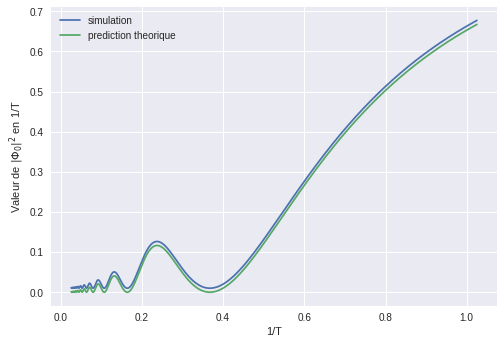

In [0]:
graphe_distance_epsilon()

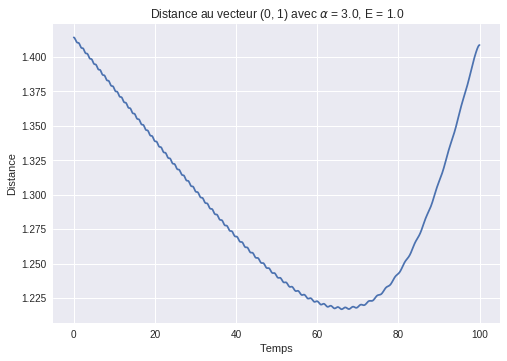

In [0]:
alpha = 3.0
E = 1.0
controle = gamma_0
T = 100.0
N = 1000

liste_tps, liste_phis = evolution_Phi(alpha, E, controle, T, N)

def distance(vec):
  return np.sqrt(np.absolute(vec[0])**2 + (1-np.absolute(vec[1]))**2)

distances = [distance(v) for v in liste_phis]
plt.plot(liste_tps, distances)
plt.title(r"Distance au vecteur (0, 1) avec $\alpha$ = 3.0, E = 1.0")
plt.xlabel("Temps")
plt.ylabel("Distance")

plt.show()


**Contrôle du système quantique à trois niveaux**

Nous considérons maintenant le système à trois niveaux d'énergie (voir le document pdf). Nous allons d'abord calculer les valeurs propres de l'hamiltonien en fonction des contrôles $u_1$ et $u_2$. On remarque que les valeurs propres sont réelles puisque la matrice est symmétrique


In [0]:
vecteur_initial3 = np.array([1.0, 0.0, 0.0], dtype=np.complex_)
vecteur_cible3 = np.array([0.0, 0.0, 1.0], dtype=np.complex_)

"""
On a vu par calcul que les singularités de notre systèmes sont situees aux points
(0, sqrt(2)) et (sqrt(2), 0)
"""

v_1 = np.sqrt(2) #valeur max que prendra u_1 en t = 2/3 dans gamma
v_2 = np.sqrt(2) #valeur max que prendra u_2 en t = 1/3 dans gamma 

T = 100.0
N = 10000

In [0]:
"""
Definition du controle
"""

def gamma3(t):
  "Retourne le couple (u_1, u_2) au temps t entre 0 et 1 pour aller de l'etat 1 \
  a l'etat 3"
  if t > 1:
    return (0, 0)
  u_2_retour = (t < 2/3)*np.sin(np.pi*3*t/2)
  u_1_retour = (t > 1/3)*np.sin(np.pi*3*(t-1/3)/2)
  return (u_1_retour, u_2_retour)

def gamma3_scale(t, v_1, v_2):
  u_1, u_2 = gamma3(t)
  return (u_1*v_1, u_2*v_2)

controle = lambda t : gamma3_scale(t, v_1, v_2)

def valeurs_controle(controle, n=100):
  dt = 1.0/float(n)
  valeurs = [], []
  ts = [0]
  for i in range(n):
    c = controle(ts[-1])
    valeurs[0].append(c[0])
    valeurs[1].append(c[1])
    ts.append(ts[-1]+dt)
  ts.pop()
  return ts, valeurs

def afficher_valeurs_controle(controle, n=100):
  ts, valeurs = valeurs_controle(controle, n)
  plt.plot(ts, valeurs[0])
  plt.plot(ts, valeurs[1])
  plt.show()
  
"""
Definition de la matrice et differentes fonctions sur ses valeurs propres
"""

def H3(u_1, u_2, alphas=None):
  if alphas == None:
      alphas = [-1.0, 0.0, 1.0]
  return np.array([
      [alphas[0], u_1, 0],
      [u_1, alphas[1], u_2],
      [0, u_2, alphas[2]]
  ])

def valeurs_propres_H3(u_1, u_2):
  valpropres = linalg.eigvalsh(H3(u_1, u_2))
  return valpropres

def surfaces_valeurs_propres(u_1_min, u_1_max, u_2_min, u_2_max, step):
  "Retourne les surfaces des valeurs propres en fonction de u_1 et u_2"
  n_1, n_2 = int((u_1_max - u_1_min)/step), int((u_2_max - u_2_min)/step)
  vp_1, vp_2, vp_3 = np.zeros((n_1, n_2)), np.zeros((n_1, n_2)), np.zeros((n_1, n_2))
  x, y = np.array([u_1_min +k*step for k in range(n_1)]), np.array([u_2_min + k*step for k in range(n_2)])
  for i in range(n_1):
    for j in range(n_2):
      u_1, u_2 = x[i], y[j]
      a, b, c = valeurs_propres_H3(u_1, u_2)
      vp_1[i, j] = a
      vp_2[i, j] = b
      vp_3[i, j] = c
  return x, y, vp_1, vp_2, vp_3

def afficher_surfaces(X, Y, vp_1, vp_2, vp_3):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  x, y = np.meshgrid(X, Y)
  ax.plot_wireframe(x, y, vp_1)
  ax.plot_wireframe(x, y, vp_2)
  ax.plot_wireframe(x, y, vp_3)
  plt.show()
  
"""
Calcul de l'evolution du systeme
"""
def derivee_Phi3(controle, Phi, alphas=None):
  u_1, u_2 = controle
  return -1j * np.dot(H3(u_1, u_2, alphas), Phi)

def evolution_Phi3(alphas, controle, T, N):
  liste_Phis = np.zeros((N, 3), dtype=np.complex_)
  liste_tps = [0.0]*N
  liste_Phis[0] = vecteur_initial3
  T = float(T)
  f = lambda t, y: derivee_Phi3(controle(t/T), y, alphas)
  r = complex_ode(f)
  r.set_initial_value(liste_Phis[0], liste_tps[0])
  dt = T/(N-1)
  k = 1
  while r.successful() and k < N: #k < N
    liste_tps[k] = r.t+dt
    liste_Phis[k] = r.integrate(r.t + dt)
    k += 1
  return liste_tps, liste_Phis

"""
Calcul des distances au temps final 
"""

def vecteur_final3(alphas, controle, T, N):
  liste_tps, liste_Phis = evolution_Phi3(alphas, controle, T, N)
  return liste_Phis[N-1]

def distance_vecteur3(vecteur):
  "Retourne la distance du vecteur au vecteur (0, 0, 1) a rotation pres"
  a, b, c = vecteur[0], vecteur[1], vecteur[2]
  return np.sqrt(np.absolute(a)**2 + np.absolute(b)**2 + (1-np.absolute(c))**2)

def distance_finale3(alphas, controle, T, N):
  return distance_vecteur3(vecteur_final(alphas, controle, T, N))





Text(0, 0.5, 'Distance à (0, 0, 1))')

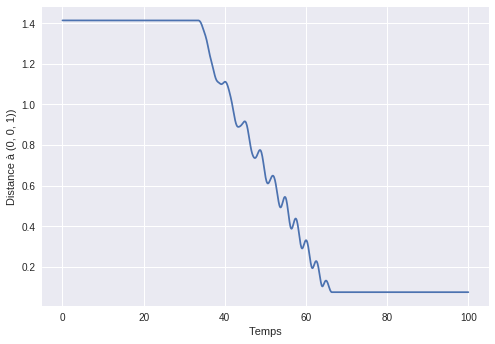

In [0]:
alphas = [-1, 1, 0]
liste_tps, liste_Phis = evolution_Phi3(alphas, controle, T, N)
distances = [distance_vecteur3(v) for v in liste_Phis]
plt.plot(np.linspace(0, T, N), distances)
plt.xlabel("Temps")
plt.ylabel("Distance à (0, 0, 1))")

Nous affichons ci dessus la distance entre notre vecteur et le vecteur (0, 0, 1) en fonction du temps. Nous observons clairement que pendant la première et la troisième phase du contrôle, la distance est inchangée.

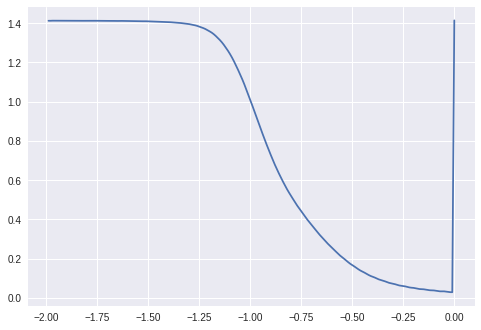

In [0]:
def variation_alpha1():
  "Nous allons faire varier alpha 1 et observer a partir de quel moment le \
  controle ne peut plus nous amener a l'etat (0, 0, 1). "
  alphas1 = [-1 - k*0.01 for k in range(-100, 100)]
  alphas = [[alphas1[i], 0.0, 1.0] for i in range(len(alphas1))]
  distances = [distance_finale3(alphas[i], controle, T, N) for i in range(len(alphas))]
  plt.plot(alphas1, distances)
  plt.show()
T = 1000
N = 3000
variation_alpha1()

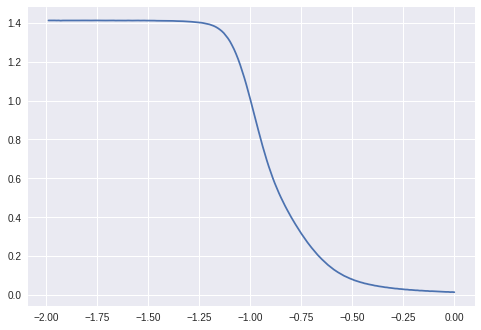

In [0]:
T = 2000
N = 6000
variation_alpha1()

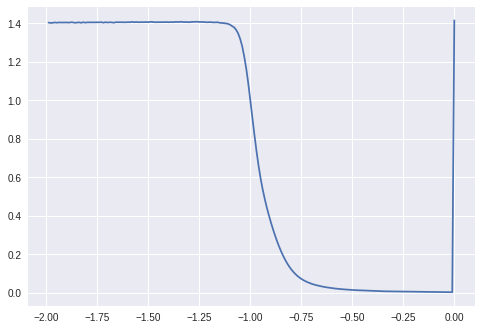

In [0]:
T = 10000
N = 100000
variation_alpha1()